In [13]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from functools import partial

import equinox as eqx

from jaxpm.painting import cic_paint, cic_paint_dx
from jaxpm.pm import linear_field, lpt, make_diffrax_ode , make_diffrax_symplectic_ode
from jaxpm.distributed import uniform_particles
from diffrax import (
    ConstantStepSize,
    LeapfrogMidpoint,
    ODETerm,
    SaveAt,
    diffeqsolve,
    Dopri5,
    SemiImplicitEuler,
    ReversibleHeun,
    Tsit5,
    PIDController,
    TqdmProgressMeter,
    RecursiveCheckpointAdjoint,
    BacksolveAdjoint,
    ImplicitAdjoint,
    DirectAdjoint,
    Euler,
)

In [24]:
mesh_shape = [128, 128, 128]
box_size = [512.0, 512.0, 512.0]
snapshots = jnp.array([0.2, 0.5, 1.0])

omega_c = 0.25
sigma8 = 0.8
cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)


@jax.jit
def run_lpt(cosmo):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(
        mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0)
    )

    # Initial displacement
    cosmo._workspace = {}
    dx, p, _ = lpt(cosmo, initial_conditions, a=0.1, order=1)

    return dx, p


dx, p = run_lpt(cosmo)

print(f"Done with LPT")

Done with LPT


In [25]:
@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def run_nbody(
    cosmo,
    y0,
    term,
    step_size=0.01,
    stepsize_controller=ConstantStepSize(),
    solver=Tsit5(),
):
    print(f"Jitted run_nbody")
    # Evolve the simulation forward
    ode_solutions = diffeqsolve(
        term,
        solver=solver,
        t0=0.1,
        t1=1.0,
        dt0=step_size,
        y0=y0,
        args=cosmo,
        stepsize_controller=stepsize_controller,
        progress_meter=TqdmProgressMeter(refresh_steps=2),
        #adjoint=BacksolveAdjoint(solver=solver),
    )

    return ode_solutions, ode_solutions.ys[-1]


@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def reverse_nbody(cosmo, y0, term, stepsize_controller, step_size=0.01, solver=Tsit5()):
    # Evolve the simulation forward
    print(f"Jitted reverse_nbody")
    ode_solutions = diffeqsolve(
        term,
        solver,
        t0=1.0,
        t1=0.1,
        dt0=-step_size,
        y0=y0,
        args=cosmo,
        stepsize_controller=stepsize_controller,
        progress_meter=TqdmProgressMeter(refresh_steps=2),
        #adjoint=BacksolveAdjoint(solver=solver),
    )

    return ode_solutions, ode_solutions.ys[-1]

In [26]:
stepsize_controller = PIDController(rtol=1e-3, atol=1e-6)
ode_term = ODETerm(make_diffrax_ode(cosmo, mesh_shape, paint_absolute_pos=False))
ode_solutions, _ = run_nbody(
    cosmo,
    jnp.stack([dx, p], axis=0),
    ode_term,
    stepsize_controller=stepsize_controller,
    solver=Dopri5(),
)


last_dx, last_p = ode_solutions.ys[-1]
stepsize_controller = PIDController(rtol=1e-3, atol=1e-6)
reverse_ode_solutions, _ = reverse_nbody(
    cosmo,
    jnp.stack([last_dx, last_p], axis=0),
    ode_term,
    stepsize_controller=stepsize_controller,
    solver=Dopri5(),
)

Jitted run_nbody


100.00%|██████████| [00:00<00:00, 135.11%/s]


Jitted reverse_nbody


100.00%|██████████| [00:01<00:00, 76.04%/s]


In [27]:
reverse_ode_solutions.stats["num_steps"], ode_solutions.stats["num_steps"]

(Array(11, dtype=int32, weak_type=True), Array(7, dtype=int32, weak_type=True))

In [28]:
def MSE(x, y):
    return jnp.mean((x - y) ** 2)


lpt_field = cic_paint_dx(dx)
reconstructed_field = cic_paint_dx(reverse_ode_solutions.ys[-1][0])
MSE(lpt_field, reconstructed_field)

Array(0.00020524, dtype=float32)

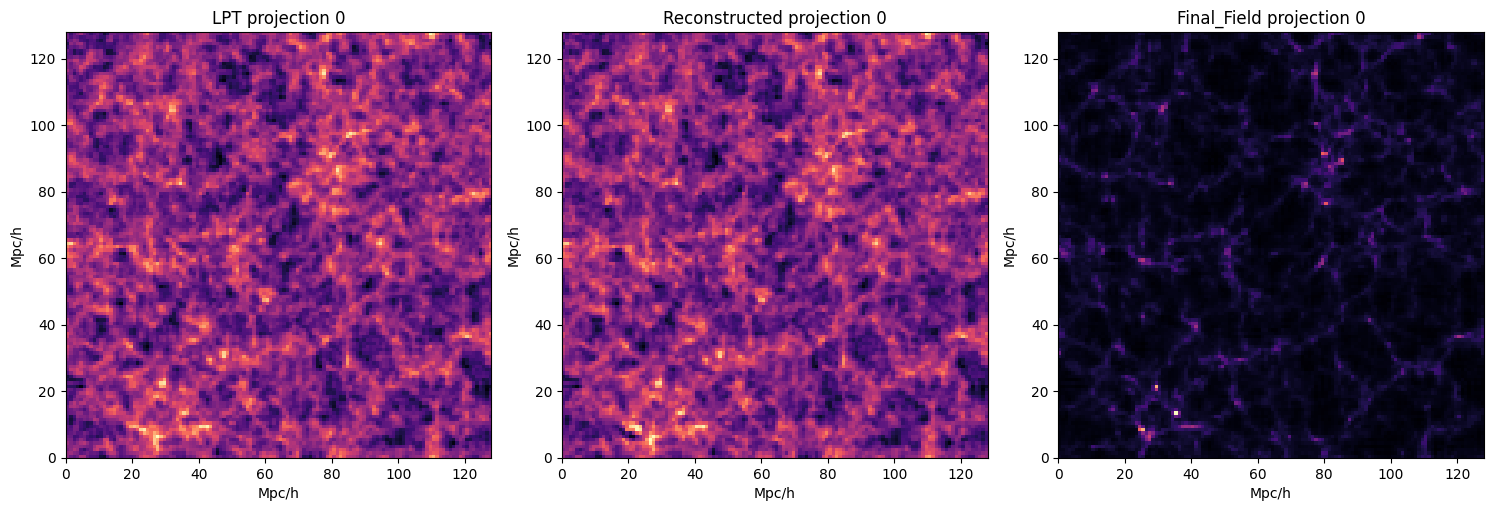

In [29]:
from jaxpm.plotting import plot_fields_single_projection

fields = {"LPT": lpt_field, "Reconstructed": reconstructed_field}

for i, snap in enumerate(ode_solutions.ys):
    fields[f"Final_Field"] = cic_paint_dx(snap[0])

plot_fields_single_projection(fields)

In [34]:
stepsize_controller = PIDController(rtol=1e-5, atol=1e-8)
ode_term = ODETerm(make_diffrax_ode(cosmo, mesh_shape, paint_absolute_pos=False))
ode_solutions_dopri, _ = run_nbody(
    cosmo,
    jnp.stack([dx, p], axis=0),
    ode_term,
    stepsize_controller=stepsize_controller,
    solver=Dopri5(),
)

ode_solutions_tsit, _ = run_nbody(
    cosmo,
    jnp.stack([dx, p], axis=0),
    ode_term,
    stepsize_controller=stepsize_controller,
    solver=Tsit5(),
)
stepsize_controller = ConstantStepSize()
ode_solutions_euler, _ = run_nbody(
    cosmo,
    jnp.stack([dx, p], axis=0),
    ode_term,
    stepsize_controller=stepsize_controller,
    solver=Euler(),
)


Jitted run_nbody


100.00%|██████████| [00:05<00:00, 18.96%/s]


Jitted run_nbody


100.00%|██████████| [00:36<00:00,  2.71%/s]


Jitted run_nbody


100.00%|██████████| [00:01<00:00, 74.16%/s]


In [35]:
y0 = dx , p
# Symplectic ODE setup for SemiImplicitEuler
kick, drift = make_diffrax_symplectic_ode(
    cosmo, mesh_shape, paint_absolute_pos=False
)
symplectic_term = (ODETerm(kick), ODETerm(drift))
#solver_ode_term = symplectic_term
stepsize_controller = ConstantStepSize()
solver = SemiImplicitEuler()

ode_solutions_syp, _ = run_nbody(
            cosmo,
            y0,
            symplectic_term,
            stepsize_controller=stepsize_controller,
            solver=solver,
            step_size=0.01,
        )

Jitted run_nbody


100.00%|██████████| [00:01<00:00, 78.59%/s]


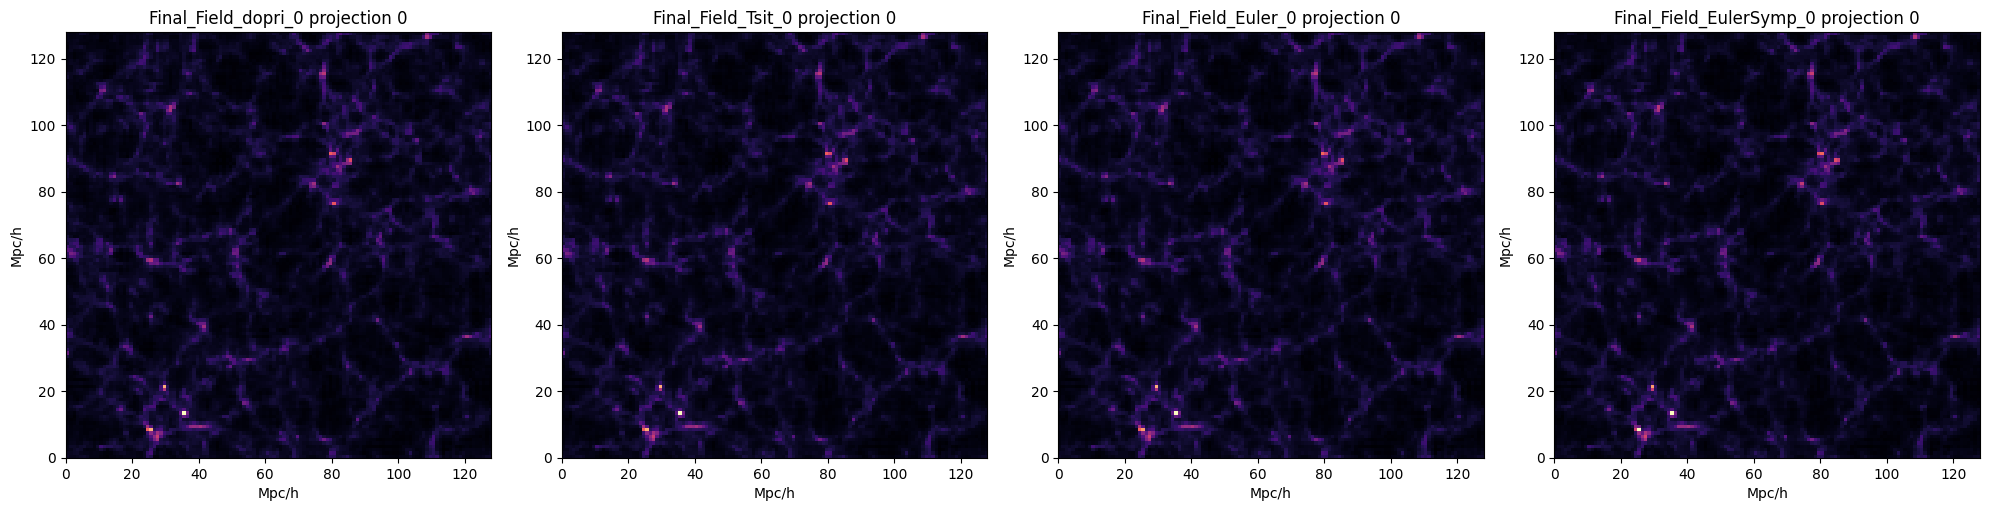

In [36]:
from jaxpm.plotting import plot_fields_single_projection

fields = {}

for i, snap in enumerate(ode_solutions_dopri.ys):
    fields[f"Final_Field_dopri_{i}"] = cic_paint_dx(snap[0])
for i, snap in enumerate(ode_solutions_tsit.ys):
    fields[f"Final_Field_Tsit_{i}"] = cic_paint_dx(snap[0])
for i, snap in enumerate(ode_solutions_euler.ys):
    fields[f"Final_Field_Euler_{i}"] = cic_paint_dx(snap[0])
for i, snap in enumerate(ode_solutions_syp.ys[0]):
    fields[f"Final_Field_EulerSymp_{i}"] = cic_paint_dx(snap)


plot_fields_single_projection(fields)

In [ ]:
for key , field in fields.items():
    for key_2 , field_2 in fields.items():
        if key == key_2:
            continue
        print(f"MSE between {key} and {key_2} is {MSE(field, field_2)}")

MSE between Final_Field_dopri_0 and Final_Field_Tsit_0 is 6.608539138142078e-08
MSE between Final_Field_dopri_0 and Final_Field_Euler_0 is 0.0019208055455237627
MSE between Final_Field_dopri_0 and Final_Field_EulerSymp_0 is 0.034730345010757446
MSE between Final_Field_Tsit_0 and Final_Field_dopri_0 is 6.608539138142078e-08
MSE between Final_Field_Tsit_0 and Final_Field_Euler_0 is 0.0019211333710700274
MSE between Final_Field_Tsit_0 and Final_Field_EulerSymp_0 is 0.03473029285669327
MSE between Final_Field_Euler_0 and Final_Field_dopri_0 is 0.0019208055455237627
MSE between Final_Field_Euler_0 and Final_Field_Tsit_0 is 0.0019211333710700274
MSE between Final_Field_Euler_0 and Final_Field_EulerSymp_0 is 0.04964469373226166
MSE between Final_Field_EulerSymp_0 and Final_Field_dopri_0 is 0.034730345010757446
MSE between Final_Field_EulerSymp_0 and Final_Field_Tsit_0 is 0.03473029285669327
MSE between Final_Field_EulerSymp_0 and Final_Field_Euler_0 is 0.04964469373226166


: 

In [11]:
from typing import List, NamedTuple
from diffrax import (
    ODETerm,
    Tsit5,
    Dopri5,
    ReversibleHeun,
    SemiImplicitEuler,
    LeapfrogMidpoint,
    Euler,
    ConstantStepSize,
    PIDController,
)


# Define a result container
class Result(NamedTuple):
    solver_name: str
    atol: List[float]  # For adaptive solvers
    rtol: List[float]  # For adaptive solvers
    step_sizes: List[float]  # For constant step solvers
    nb_steps_forward: List[int]
    nb_steps_backward: List[int]
    mse: List[float]


# Solvers
adaptive_solvers = [
    (Tsit5(), "Tsit5"),
    (Dopri5(), "Dopri5"),
    (ReversibleHeun(), "ReversibleHeun"),
]
constant_step_solvers = [
    (SemiImplicitEuler(), "SemiImplicitEuler"),
    (LeapfrogMidpoint(), "LeapfrogMidpoint"),
    (Euler(), "Euler"),
]

In [12]:
from jaxpm.pm import make_diffrax_ode,make_diffrax_symplectic_ode 

# Symplectic ODE setup for SemiImplicitEuler
nbody_ode_pos, nbody_ode_vel = make_diffrax_symplectic_ode(
    cosmo, mesh_shape, paint_absolute_pos=False
)
symplectic_term = (ODETerm(nbody_ode_pos), ODETerm(nbody_ode_vel))

# Standard ODE setup
ode_term = ODETerm(make_diffrax_ode(cosmo, mesh_shape, paint_absolute_pos=False))

In [13]:
# Initialize results
results = {}
for solver, solver_name in adaptive_solvers:
    results[solver_name] = Result(solver_name, [], [], [], [], [], [])
for solver, solver_name in constant_step_solvers:
    results[solver_name] = Result(solver_name, [], [], [], [], [], [])

In [ ]:
# Run experiments for adaptive solvers
for solver, solver_name in adaptive_solvers:
    for tol in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
        rtol = tol
        atol = tol * 1e-3
        # Set up adaptive step controller
        stepsize_controller = PIDController(rtol=rtol, atol=atol)
        ode_solutions, _ = run_nbody(
            cosmo,
            jnp.stack([dx, p], axis=0),
            ode_term,
            stepsize_controller=stepsize_controller,
            solver=solver,
        )

        # Reverse solve
        last_dx, last_p = ode_solutions.ys[-1]
        reverse_ode_solutions, _ = reverse_nbody(
            cosmo,
            jnp.stack([last_dx, last_p], axis=0),
            ode_term,
            stepsize_controller=stepsize_controller,
            solver=solver,
        )

        # Compare fields
        lpt_field = cic_paint_dx(dx)
        reconstructed_field = cic_paint_dx(reverse_ode_solutions.ys[-1][0])
        mse = MSE(lpt_field, reconstructed_field)

        # Store results
        print(
            f"Solver={solver_name}, tol={tol}, MSE={mse:.6e}, "
            f"Steps forward={ode_solutions.stats['num_steps']}, "
            f"Steps reverse={reverse_ode_solutions.stats['num_steps']}"
        )

        results[solver_name].atol.append(atol)
        results[solver_name].rtol.append(rtol)
        results[solver_name].mse.append(mse)
        results[solver_name].nb_steps_forward.append(ode_solutions.stats["num_steps"])
        results[solver_name].nb_steps_backward.append(
            reverse_ode_solutions.stats["num_steps"]
        )








100.00%|██████████| [00:00<00:00, 192.46%/s]






100.00%|██████████| [00:00<00:00, 202.64%/s]


Solver=Tsit5, tol=0.1, MSE=4.392261e-02, Steps forward=5, Steps reverse=4
Jitted run_nbody








100.00%|██████████| [00:00<00:00, 105.00%/s]


Jitted reverse_nbody








100.00%|██████████| [00:00<00:00, 140.78%/s]


Solver=Dopri5, tol=0.1, MSE=7.519263e-02, Steps forward=4, Steps reverse=4
Jitted run_nbody









100.00%|██████████| [00:00<00:00, 615.18%/s]


Jitted reverse_nbody






















































100.00%|██████████| [00:02<00:00, 42.49%/s] 


Solver=ReversibleHeun, tol=0.1, MSE=1.270668e-02, Steps forward=9, Steps reverse=99


In [ ]:
# Run experiments for constant step solvers
for solver, solver_name in constant_step_solvers:
    for steps in [5, 10 , 20, 50, 100 , 150 , 200 , 300]:
        # Calculate step size based on the number of steps
        step_size = (1.0 - 0.1) / steps

        if solver_name == "SemiImplicitEuler":
            y0 = dx , p
            solver_ode_term = symplectic_term
        else:
            y0 = jnp.stack([dx, p], axis=0)
            solver_ode_term = ODETerm(make_diffrax_ode(cosmo, mesh_shape, paint_absolute_pos=False))

        stepsize_controller = ConstantStepSize()
        ode_solutions, _ = run_nbody(
            cosmo,
            y0,
            solver_ode_term,
            stepsize_controller=stepsize_controller,
            solver=solver,
            step_size=step_size,
        )
        if solver_name == "SemiImplicitEuler":
            y1 = (ode_solutions.ys[0][-1], ode_solutions.ys[1][-1])
        else:
            y1 = ode_solutions.ys[-1]
        # Reverse solve
        reverse_ode_solutions, _ = reverse_nbody(
            cosmo,
            y1,
            solver_ode_term,
            stepsize_controller=stepsize_controller,
            solver=solver,
            step_size=step_size,
        )

        # Compare fields
        lpt_field = cic_paint_dx(dx)
        reconstructed_field = cic_paint_dx(reverse_ode_solutions.ys[-1][0])
        mse = MSE(lpt_field, reconstructed_field)

        # Store results
        print(
            f"Solver={solver_name}, steps={steps}, MSE={mse:.6e}, "
            f"Steps forward={ode_solutions.stats['num_steps']}, "
            f"Steps reverse={reverse_ode_solutions.stats['num_steps']}"
        )

        results[solver_name].step_sizes.append(step_size)
        results[solver_name].mse.append(mse)
        results[solver_name].nb_steps_forward.append(ode_solutions.stats["num_steps"])
        results[solver_name].nb_steps_backward.append(
            reverse_ode_solutions.stats["num_steps"]
        )





100.00%|██████████| [00:00<00:00, 1489.07%/s]




100.00%|██████████| [00:00<00:00, 1466.64%/s]


Solver=SemiImplicitEuler, steps=5, MSE=3.872637e+00, Steps forward=5, Steps reverse=5









100.00%|██████████| [00:00<00:00, 730.66%/s]







100.00%|██████████| [00:00<00:00, 731.34%/s]


Solver=SemiImplicitEuler, steps=10, MSE=4.972393e+00, Steps forward=10, Steps reverse=10
Jitted run_nbody






100.00%|██████████| [00:00<00:00, 1409.83%/s]


Jitted reverse_nbody






100.00%|██████████| [00:00<00:00, 1418.28%/s]


Solver=LeapfrogMidpoint, steps=5, MSE=2.488673e+00, Steps forward=5, Steps reverse=5
Jitted run_nbody









100.00%|██████████| [00:00<00:00, 617.37%/s]


Jitted reverse_nbody









100.00%|██████████| [00:00<00:00, 682.29%/s]


Solver=LeapfrogMidpoint, steps=10, MSE=4.289253e-01, Steps forward=10, Steps reverse=10
Jitted run_nbody






100.00%|██████████| [00:00<00:00, 1458.62%/s]


Jitted reverse_nbody






100.00%|██████████| [00:00<00:00, 1560.25%/s]


Solver=Euler, steps=5, MSE=8.366022e-02, Steps forward=5, Steps reverse=5
Jitted run_nbody









100.00%|██████████| [00:00<00:00, 651.92%/s]


Jitted reverse_nbody









100.00%|██████████| [00:00<00:00, 633.22%/s]

Solver=Euler, steps=10, MSE=6.457826e-02, Steps forward=10, Steps reverse=10


In [ ]:
import pickle

with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)
